# 0.0 Overview plots

In [13]:

""" 
IMPORTS
"""
import os
import numpy as np
import seaborn as sns
from collections import defaultdict
import pandas as pd
import pickle

from one.api import ONE
from pprint import pprint
import matplotlib.pyplot as plt
from scipy.stats import mode

# --Machine learning and statistics
from sklearn.metrics.pairwise import cosine_similarity
from scipy.spatial import distance_matrix, distance

# Get my functions
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//2_fit_models/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from preprocessing_functions import idxs_from_files
functions_path =  '/home/ines/repositories/representation_learning_variability/Models/Sub-trial//3_postprocess_results/'
# functions_path = '/Users/ineslaranjeira/Documents/Repositories/representation_learning_variability//Models/Sub-trial//2_fit_models/'
os.chdir(functions_path)
from postprocessing_functions import remove_states_str, state_identifiability, align_bin_design_matrix, states_per_trial_phase, broader_label
from plotting_functions import plot_avg_state, wheel_over_wavelet_clusters, plot_states_aligned
functions_path =  '/home/ines/repositories/representation_learning_variability/Functions/'
os.chdir(functions_path)
from data_processing import save_and_log
one = ONE(mode='remote')

## Parameters

In [14]:
# Parameters
bin_size = 0.017
multiplier = 1
num_states = 2
num_iters = 100
threshold = 0.05
sticky = False
optimal_k = 4
num_train_batches = 20

event_type_list = ['goCueTrigger_times']  # , 'feedback_times', 'firstMovement_times'
event_type_name = ['Go cue']  # , 'Feedback time', 'First movement onset'

save_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'

# LOAD DATA
data_path ='/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Design matrix/' + 'v5_15Jan2025/' + str(bin_size) + '/'
all_files = os.listdir(data_path)
design_matrices = [item for item in all_files if 'design_matrix' in item and 'standardized' not in item]
idxs, mouse_names = idxs_from_files(design_matrices, bin_size)

states_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'
wavelet_states_path = '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/'  + str(bin_size) + '/wavelet_transform_states/'

use_sets = [['whisker_me'], ['Lick count'], ['0.5',
    '1.0', '2.0', '4.0', '8.0']]
use_sets = [['avg_wheel_vel'], ['whisker_me'], ['Lick count'], ['0.25', '0.5',
    '1.0', '2.0', '4.0', '8.0', '16.0']]
var_interest_map = ['whisker_me', 'Lick count', 'wavelet']
var_interest_map = ['wavelet', 'whisker_me', 'Lick count']

path_sets = [wavelet_states_path, states_path, states_path]

idx_init_list = [1, 2, 4]
idx_end_list = [2, 3, 8]
# var_interest = 'avg_wheel_vel'

# Did this on the 28th February!!!!! dataset from a week before was scrambled
identifiable_mapping = {'000': 0.0,
           '100': 1.0,
           '200': 2.0,
           '300': 3.0,
           '010': 4.0,
           '110': 5.0,
           '210': 6.0,
           '310': 7.0,
           '001': 8.0,
           '101': 9.0,
           '201': 10.0,
           '301': 11.0, 
           '011': 12.0,
           '111': 13.0,
           '211': 14.0,
           '311': 15.0,
           'nan': np.nan
           }

# Individual sessions

In [7]:
# Identify sessions available to process
sessions_to_process = []
for m, mat in enumerate(idxs):
    mouse_name = mat[37:]
    session = mat[:36]
    fit_id = str(mouse_name + session)
    whisker_filename = os.path.join(states_path, "most_likely_states" + 'whisker_me' + '_' + fit_id)
    licks_filename = os.path.join(states_path, "most_likely_states" + 'Lick count' + '_' + fit_id)
    wavelet_filename = os.path.join(wavelet_states_path, "most_likely_states_" + str(optimal_k) + '_' + fit_id)

    if os.path.exists(whisker_filename) and os.path.exists(licks_filename) and os.path.exists(wavelet_filename):
        sessions_to_process.append((mouse_name, session))

print(f"Found {len(sessions_to_process)} sessions to process.")

Found 215 sessions to process.


In [8]:
# Load preprocessed data
results_path = '/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/'
filename_states = str(results_path + 'states_trial_type02-28-2025')
states_file = pd.read_parquet(filename_states, engine='pyarrow')

In [ ]:
all_cluster_features = pd.DataFrame(columns=['mouse_name', 'session', 'most_likely_state', 'abs_wheel_vel', '0.5', 
                                                                                            '1.0', '2.0', '4.0', '8.0'])
index_var = np.where(np.array(var_interest_map)==var_interest)[0][0]
idx_init = idx_init_list[index_var]
idx_end = idx_end_list[index_var]
var_names = use_sets[index_var]

for m, mat in enumerate(sessions_to_process):

    mouse_name = mat[0]
    session = mat[1]
    fit_id = str(mouse_name+session)

    # Get session data
    filename = data_path + "session_trials_" + str(session) + '_'  + mouse_name
    session_trials = pd.read_parquet(filename, engine='pyarrow').reset_index()  # I think resetting index is what gives the trial number?
    # Get design_matrix
    filename = data_path + "design_matrix_" + str(session) + '_'  + mouse_name
    unnorm_design_matrix =  pd.read_parquet(filename, engine='pyarrow').dropna().reset_index()
    # Get session data
    filename = data_path + "standardized_design_matrix_" + str(session) + '_'  + mouse_name
    standardized_designmatrix = np.load(filename+str('.npy'))
    filtered_matrix = standardized_designmatrix[~np.isnan(standardized_designmatrix).any(axis=1)]  # Need to dropnans
    # design_matrix = np.abs(filtered_matrix.copy()[:, idx_init:idx_end])
    design_matrix = filtered_matrix.copy()[:, idx_init:idx_end]
    num_timesteps = np.shape(design_matrix)[0]
    data = design_matrix[:(num_timesteps // num_train_batches) * num_train_batches]

    """ Load wavelet states """
    # Save most_likely_states
    states_results_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/wavelet_transform_states/'
    states = pickle.load(open(states_results_path + "most_likely_states" + '_'+str(optimal_k)+'_'+ fit_id, "rb"))
    
    " Prepare data "
    num_timesteps = np.shape(design_matrix)[0]
    use_var = ['avg_wheel_vel', '0.5', '1.0', '2.0', '4.0', '8.0']
    design_matrix_heading = pd.DataFrame(columns=use_var)
    design_matrix_heading[var_names] = design_matrix[0:len(states)]  # TODO: need to understand why number is the same and whether it depends on lag
    bins = unnorm_design_matrix[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
    design_matrix_heading['Bin'] = bins
    design_matrix_heading['avg_wheel_vel'] = filtered_matrix[:len(data), 0]

    # Align bins
    init = -1 * multiplier
    end = 1.5 * multiplier
    empirical_data = align_bin_design_matrix(init, end, event_type_list, session_trials, design_matrix_heading, states, multiplier)
    # empirical_data = empirical_data.drop(columns=['new_bin'])
    # empirical_data['identifiable_states'] = identifiable_states
    
    """ Trial types """
    # Split in trial types
    states_trial = states_per_trial_phase(empirical_data, session_trials, multiplier)
    states_trial['mouse_name'] = mouse_name
    states_trial['session'] = session
    states_trial = broader_label(states_trial)
    
    # # Plot raw trace over states       
    # init = 400
    # inter = 1000
    # wheel_over_wavelet_clusters(init, inter, empirical_data, session_trials)
    # print(session)
    
    # Plot states statistics
    use_df = unnorm_design_matrix[:(num_timesteps // num_train_batches) * num_train_batches]
    bins = use_df[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
    use_df['Bin'] = bins
    use_df['avg_wheel_vel'] = filtered_matrix[:len(data), 0]


In [9]:
var_names = ['avg_wheel_vel',  'whisker_me', 'Lick count']

for m, mat in enumerate(sessions_to_process[:1]):

    mouse_name = mat[0]
    session = mat[1]
    fit_id = str(mouse_name+session)
    
    states_trial = states_file.loc[states_file['session']==session]
    num_states = len(states_trial['most_likely_states'].unique())

    """ Stack trial states """
    trial_init = 10  # First trial to plot
    trials_to_plot = 20  # How many trials to plot (if very different will compromise readibility)
    plot_states_aligned_trial(trial_init, empirical_data, session_trials, bin_size, trials_to_plot, inverted_mapping)

    " Plot states stacked and aligned per trial type "
    plot_states_aligned(init, end, empirical_data, event_type_name, bin_size, inverted_mapping)
    
    """ Plot states per trial epoch """
    colors = sns.color_palette("viridis", num_states)
    # states_trial = states_per_trial_phase(empirical_data, session_trials, multiplier)
    states_trial = states_per_trial_phase(empirical_data, session_trials, multiplier)
    sns.histplot(x='label', hue='most_likely_states', data=states_trial, stat = 'percent',
                        multiple="stack", legend=True, palette='viridis', alpha=0.3)
    # plt.figure(figsize=[7, 5])
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.title(mouse_name)
    plt.show()

    """ Plot raw traces over states """
    init = int(np.min(empirical_data['Bin'])/10+10) * multiplier # First bin
    init = 250*multiplier
    inter = 10 * multiplier
    inter = 20 * multiplier
    traces_over_few_sates(init, inter, empirical_data, session_trials, var_names, multiplier, inverted_mapping)
            

In [10]:
states_trial

,avg_wheel_vel,whisker_me,Lick count,Bin,most_likely_states,correct,choice,contrast,block,reaction,response,elongation,wsls,trial_id,goCueTrigger_times,identifiable_states,label,mouse_name,session,broader_label
169,-0.463067,1.712142,0.0,40.591507,4.0,1.0,right,0.250,0.5,0.275246,0.562108,1.084715,wsh,1.0,42.126389,010,Pre-quiescence,ZFM-02372,88224abb-5746-431f-9c17-17d7ef806e6a,Pre-quiescence
170,-0.997548,1.416532,0.0,40.608139,4.0,1.0,right,0.250,0.5,0.275246,0.562108,1.084715,wsh,1.0,42.126389,010,Pre-quiescence,ZFM-02372,88224abb-5746-431f-9c17-17d7ef806e6a,Pre-quiescence
171,-1.225261,1.585616,0.0,40.624804,4.0,1.0,right,0.250,0.5,0.275246,0.562108,1.084715,wsh,1.0,42.126389,010,Pre-quiescence,ZFM-02372,88224abb-5746-431f-9c17-17d7ef806e6a,Pre-quiescence
172,-1.157056,1.921775,0.0,40.641435,4.0,1.0,right,0.250,0.5,0.275246,0.562108,1.084715,wsh,1.0,42.126389,010,Pre-quiescence,ZFM-02372,88224abb-5746-431f-9c17-17d7ef806e6a,Pre-quiescence
173,-1.121603,3.063790,0.0,40.658067,4.0,1.0,right,0.250,0.5,0.275246,0.562108,1.084715,wsh,1.0,42.126389,010,Pre-quiescence,ZFM-02372,88224abb-5746-431f-9c17-17d7ef806e6a,Pre-quiescence
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
128889,0.012170,-0.797199,0.0,2182.721873,1.0,1.0,left,0.125,0.2,11.150875,11.891767,0.104219,lst,450.0,2166.536614,100,Quiescence,ZFM-02372,88224abb-5746-431f-9c17-17d7ef806e6a,Quiescence
128890,0.012170,-0.569753,0.0,2182.738504,1.0,1.0,left,0.125,0.2,11.150875,11.891767,0.104219,lst,450.0,2166.536614,100,Quiescence,ZFM-02372,88224abb-5746-431f-9c17-17d7ef806e6a,Quiescence
128891,0.012169,-0.613638,0.0,2182.755136,1.0,1.0,left,0.125,0.2,11.150875,11.891767,0.104219,lst,450.0,2166.536614,100,Quiescence,ZFM-02372,88224abb-5746-431f-9c17-17d7ef806e6a,Quiescence
128892,0.012170,-0.744976,0.0,2182.771801,1.0,1.0,left,0.125,0.2,11.150875,11.891767,0.104219,lst,450.0,2166.536614,100,Quiescence,ZFM-02372,88224abb-5746-431f-9c17-17d7ef806e6a,Quiescence


/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_feedback'][1:] = trials['feedbackType'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

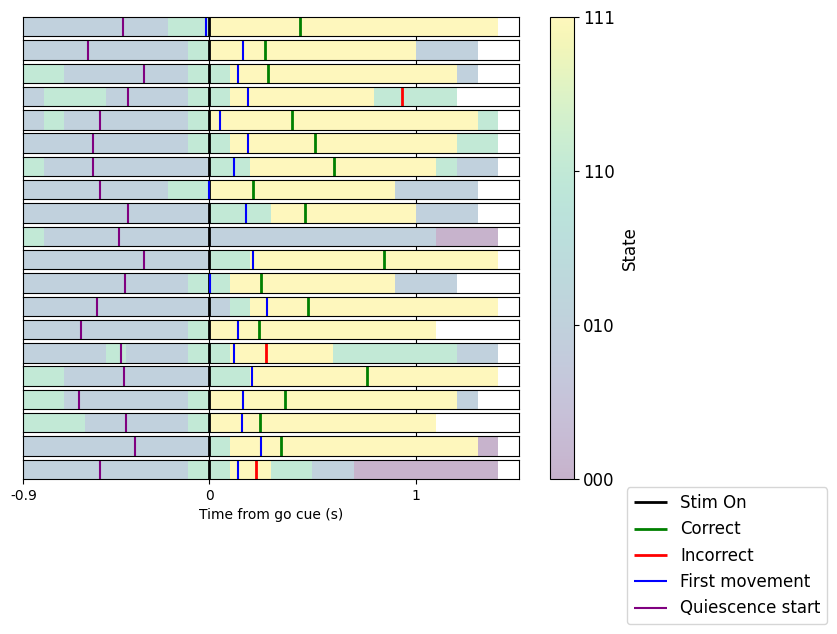

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:648: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


[]


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:677: UserWarning: Mismatched number of handles and labels: len(handles) = 0 len(labels) = 4
  ax[0, 0].legend(handles=handles, labels=ordered_labels, loc='upper left', bbox_to_anchor=(1, 1))
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:677: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0, 0].legend(handles=handles, labels=ordered_labels, loc='upper left', bbox_to_anchor=(1, 1))


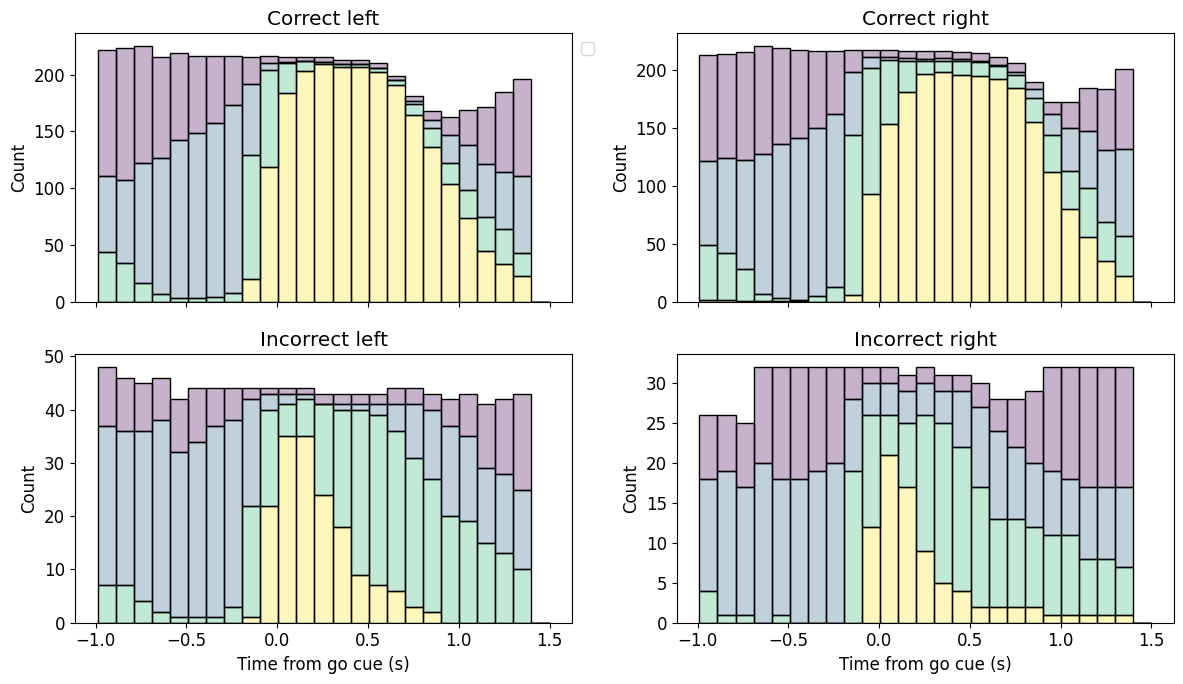

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['label'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on 

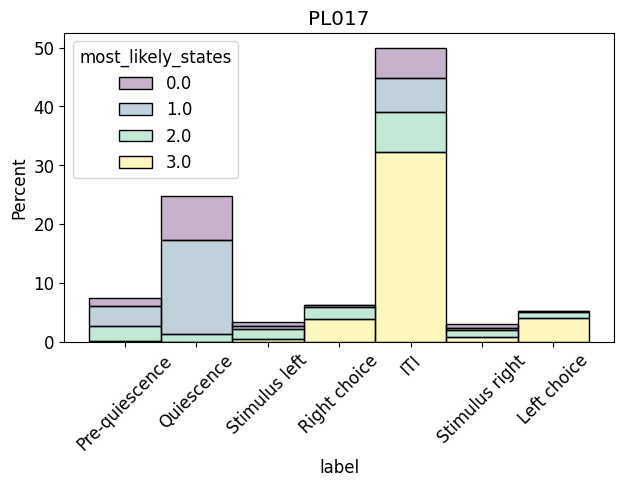

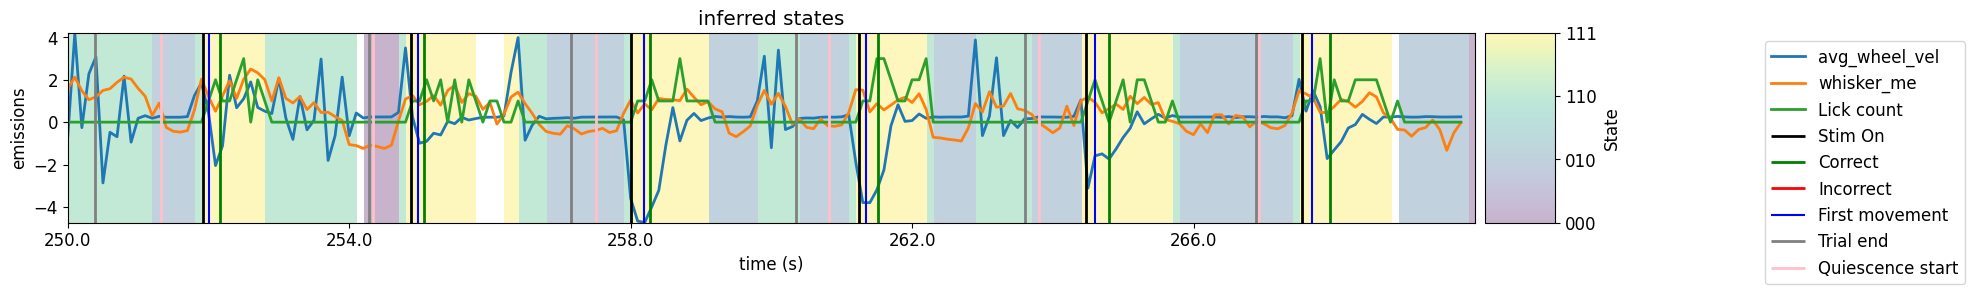

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_feedback'][1:] = trials['feedbackType'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

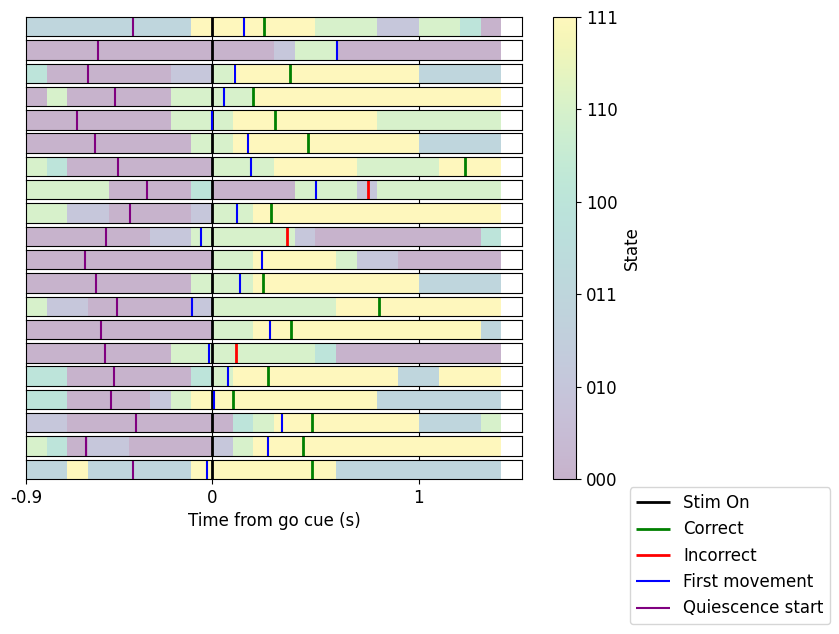

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:648: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


[]


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:677: UserWarning: Mismatched number of handles and labels: len(handles) = 0 len(labels) = 6
  ax[0, 0].legend(handles=handles, labels=ordered_labels, loc='upper left', bbox_to_anchor=(1, 1))
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:677: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0, 0].legend(handles=handles, labels=ordered_labels, loc='upper left', bbox_to_anchor=(1, 1))


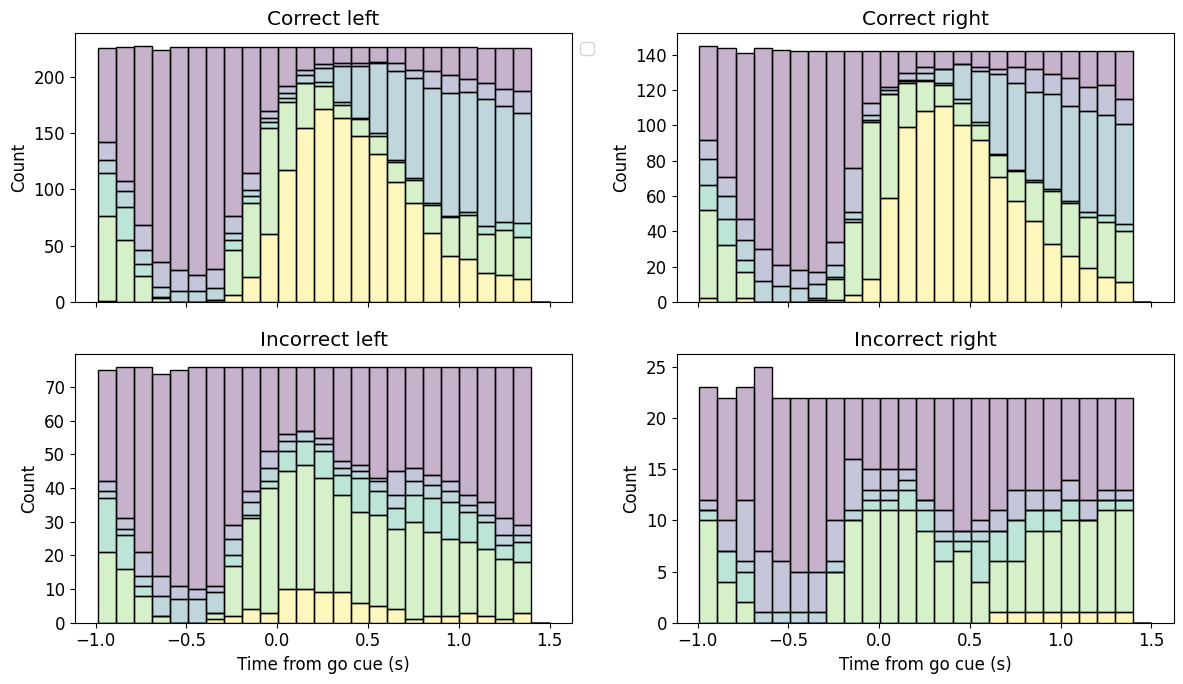

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['label'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on 

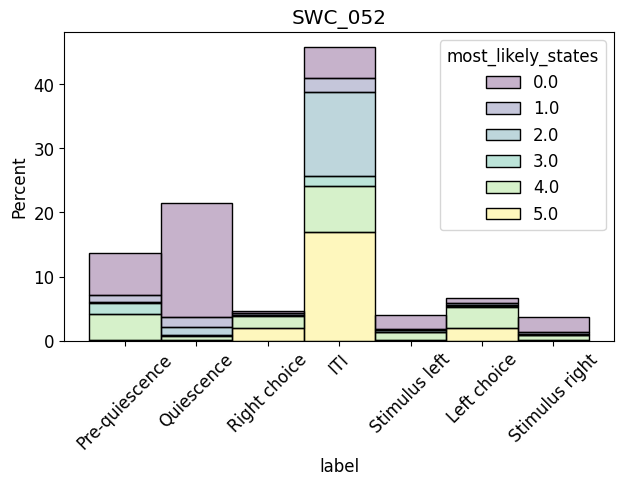

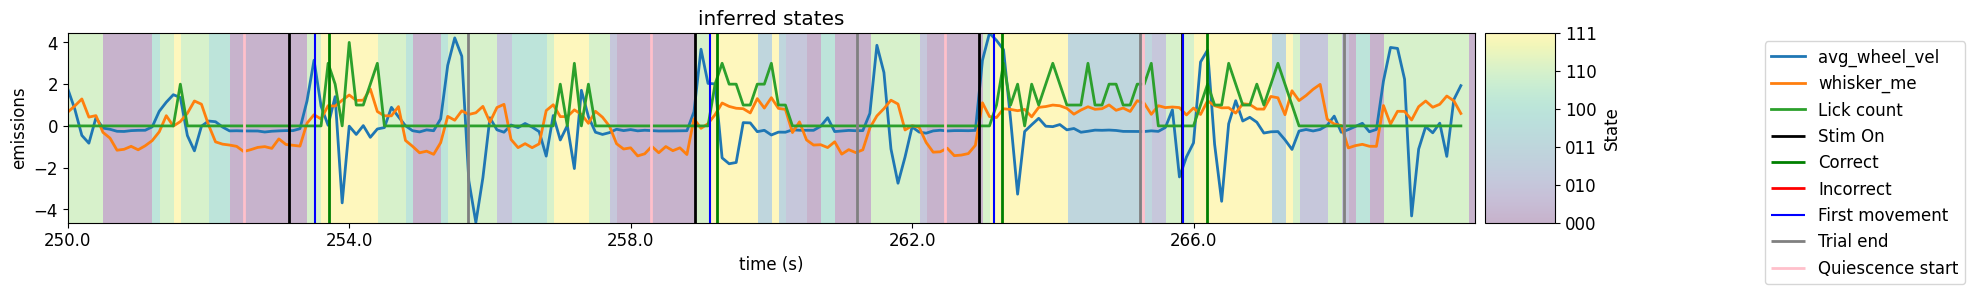

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_feedback'][1:] = trials['feedbackType'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

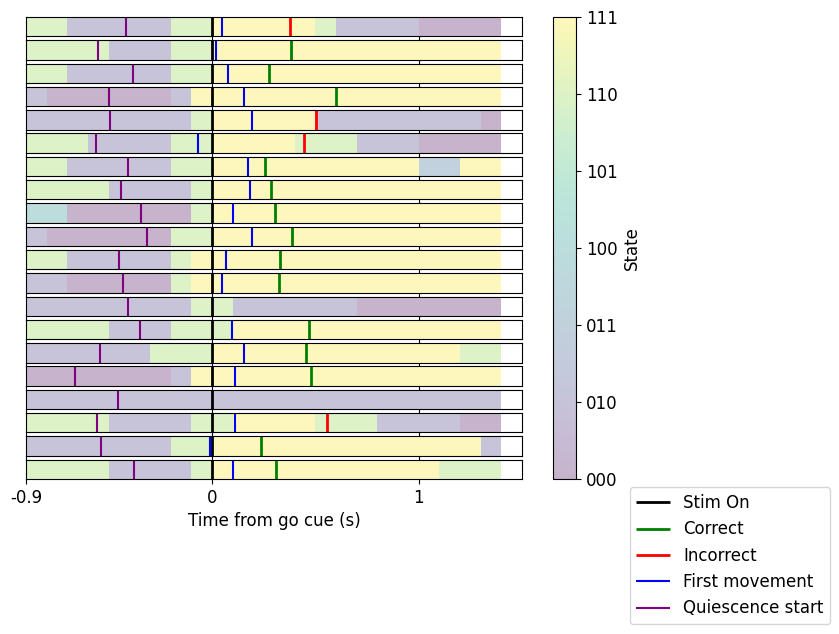

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:648: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


[]


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:677: UserWarning: Mismatched number of handles and labels: len(handles) = 0 len(labels) = 7
  ax[0, 0].legend(handles=handles, labels=ordered_labels, loc='upper left', bbox_to_anchor=(1, 1))
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:677: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0, 0].legend(handles=handles, labels=ordered_labels, loc='upper left', bbox_to_anchor=(1, 1))


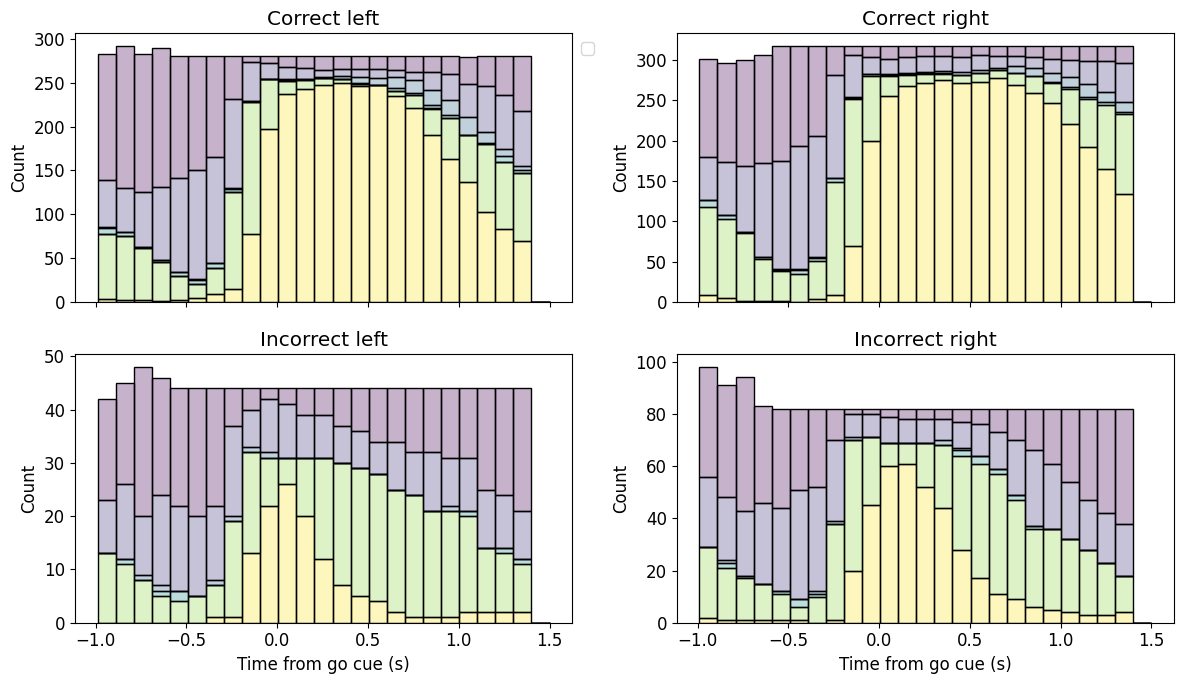

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['label'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on 

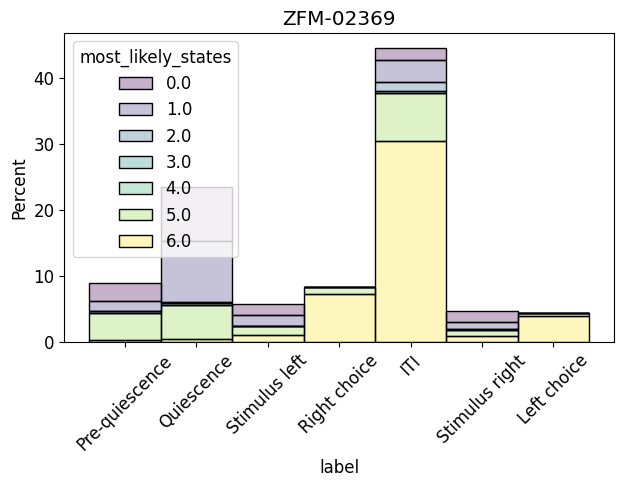

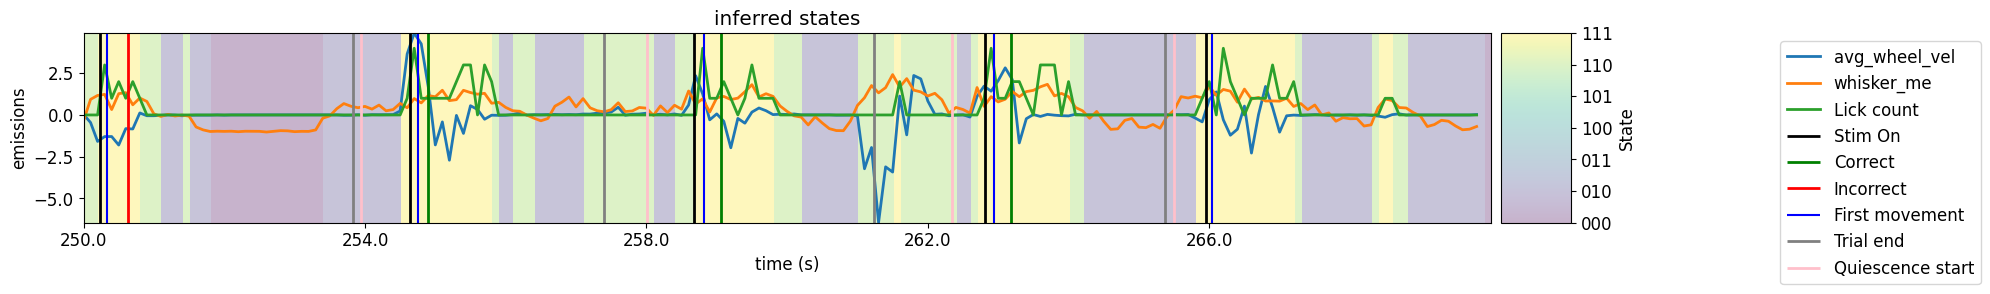

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_feedback'][1:] = trials['feedbackType'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

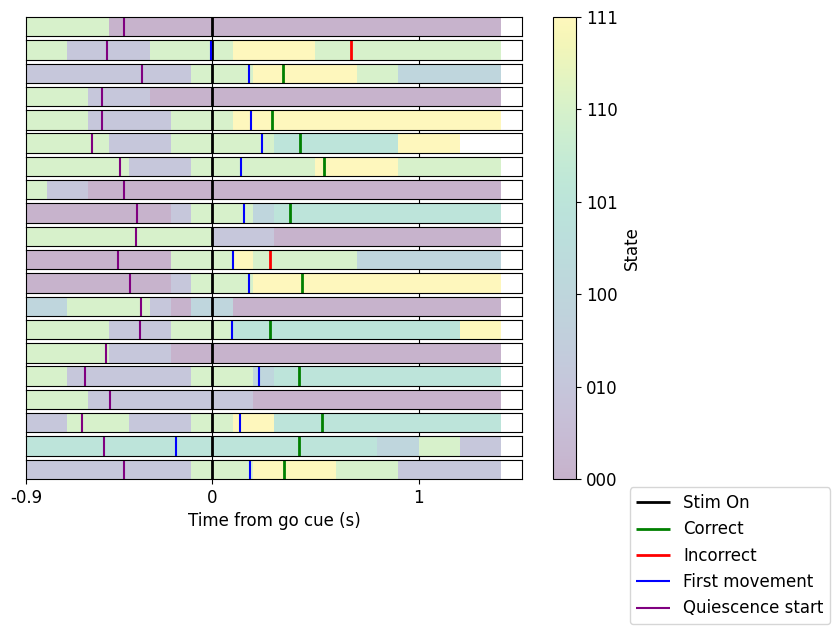

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:648: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


[]


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:677: UserWarning: Mismatched number of handles and labels: len(handles) = 0 len(labels) = 6
  ax[0, 0].legend(handles=handles, labels=ordered_labels, loc='upper left', bbox_to_anchor=(1, 1))
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:677: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0, 0].legend(handles=handles, labels=ordered_labels, loc='upper left', bbox_to_anchor=(1, 1))


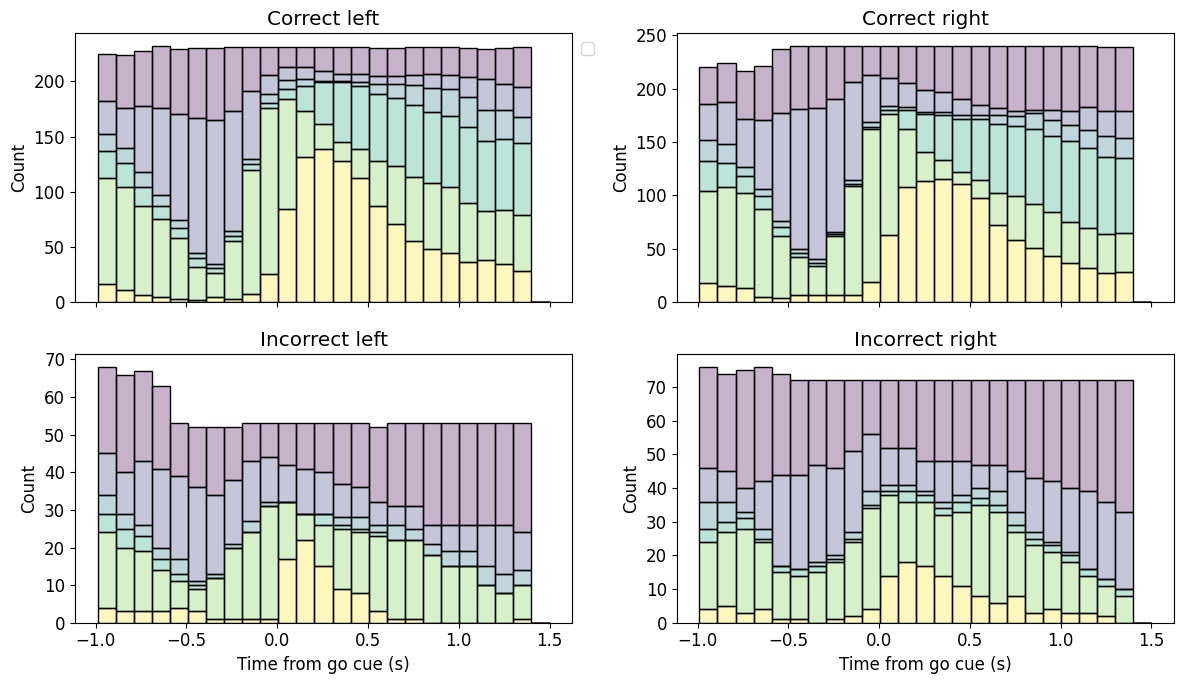

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['label'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on 

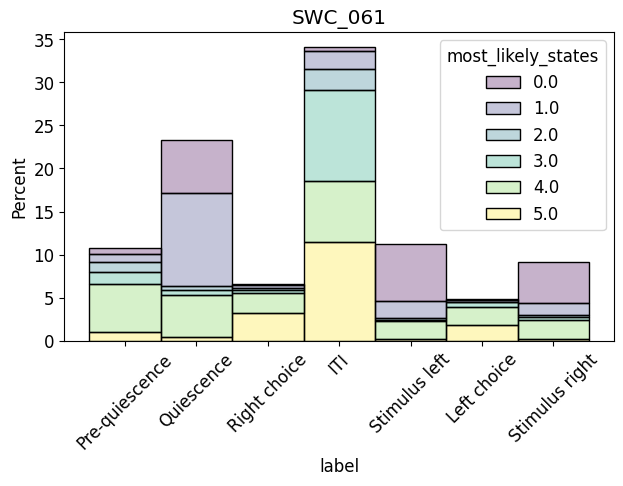

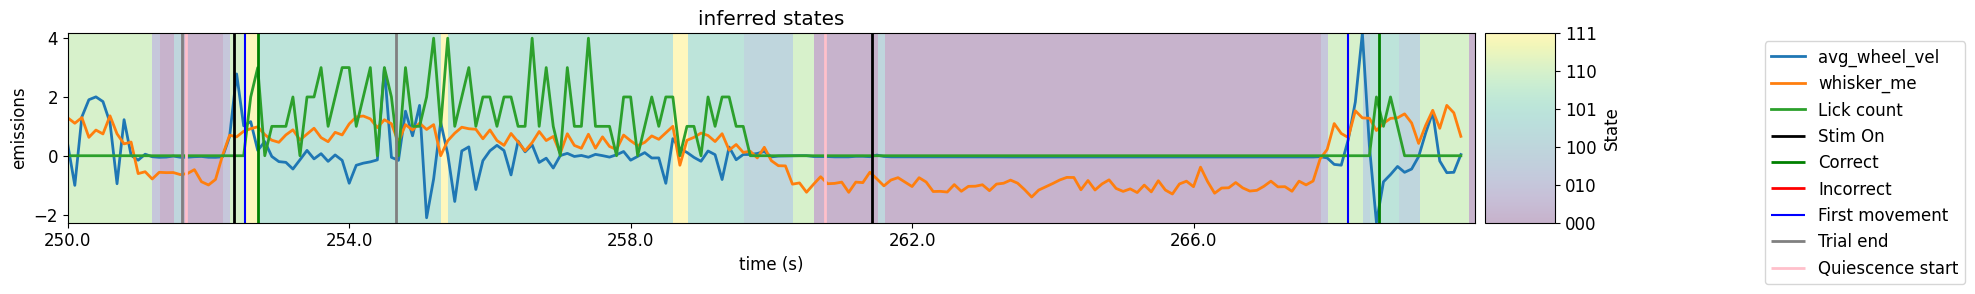

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_feedback'][1:] = trials['feedbackType'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

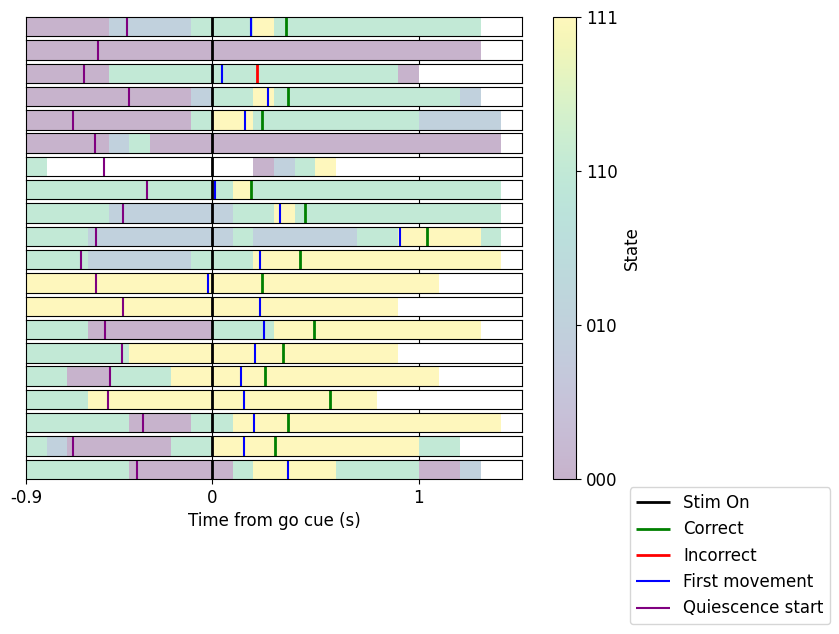

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:648: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


[]


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:677: UserWarning: Mismatched number of handles and labels: len(handles) = 0 len(labels) = 4
  ax[0, 0].legend(handles=handles, labels=ordered_labels, loc='upper left', bbox_to_anchor=(1, 1))
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:677: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0, 0].legend(handles=handles, labels=ordered_labels, loc='upper left', bbox_to_anchor=(1, 1))


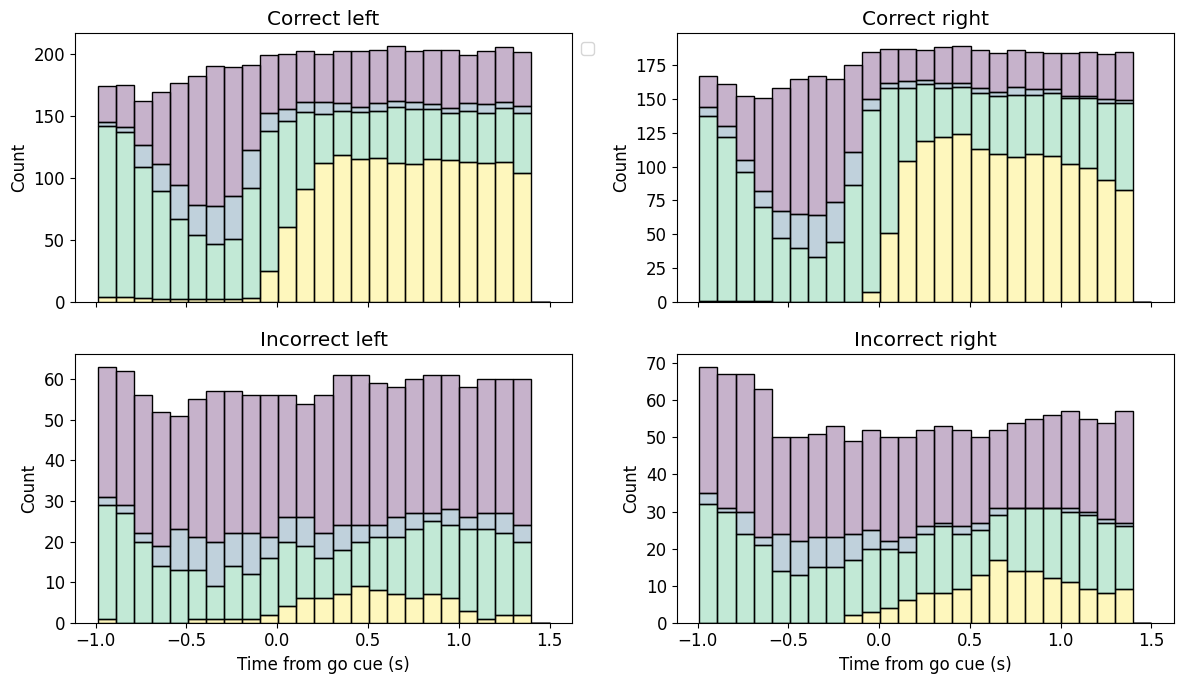

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['label'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on 

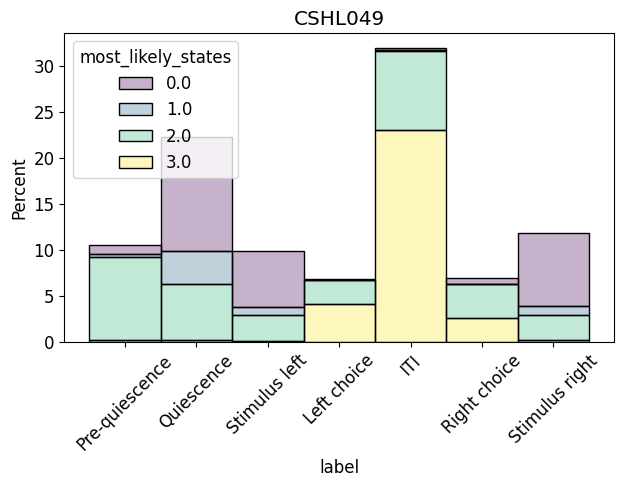

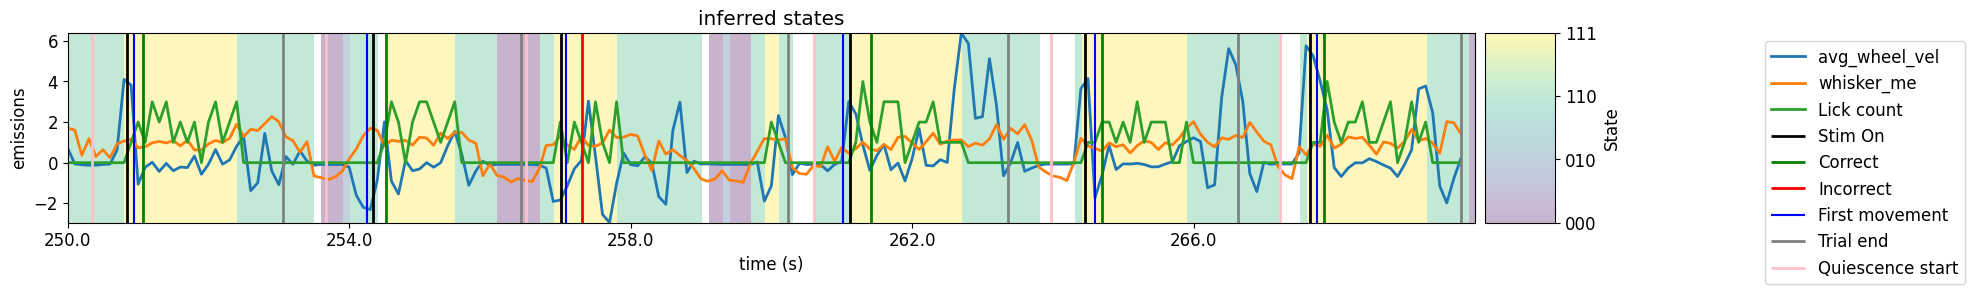

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_feedback'][1:] = trials['feedbackType'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

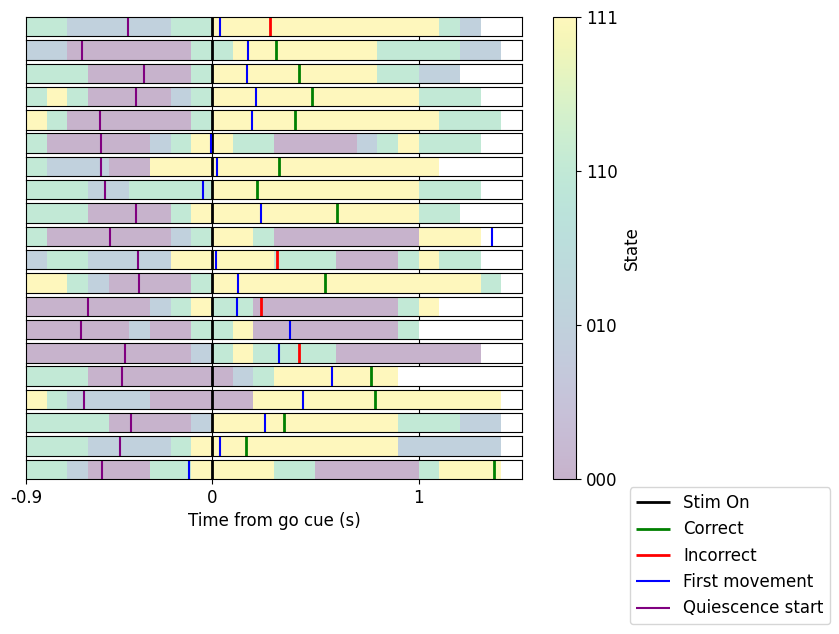

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:648: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:677: UserWarning: Mismatched number of handles and labels: len(handles) = 0 len(labels) = 4
  ax[0, 0].legend(handles=handles, labels=ordered_labels, loc='upper left', bbox_to_anchor=(1, 1))
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:677: UserWarning: No artists with labels found to put in legend.  Note that artists whose label st

[]


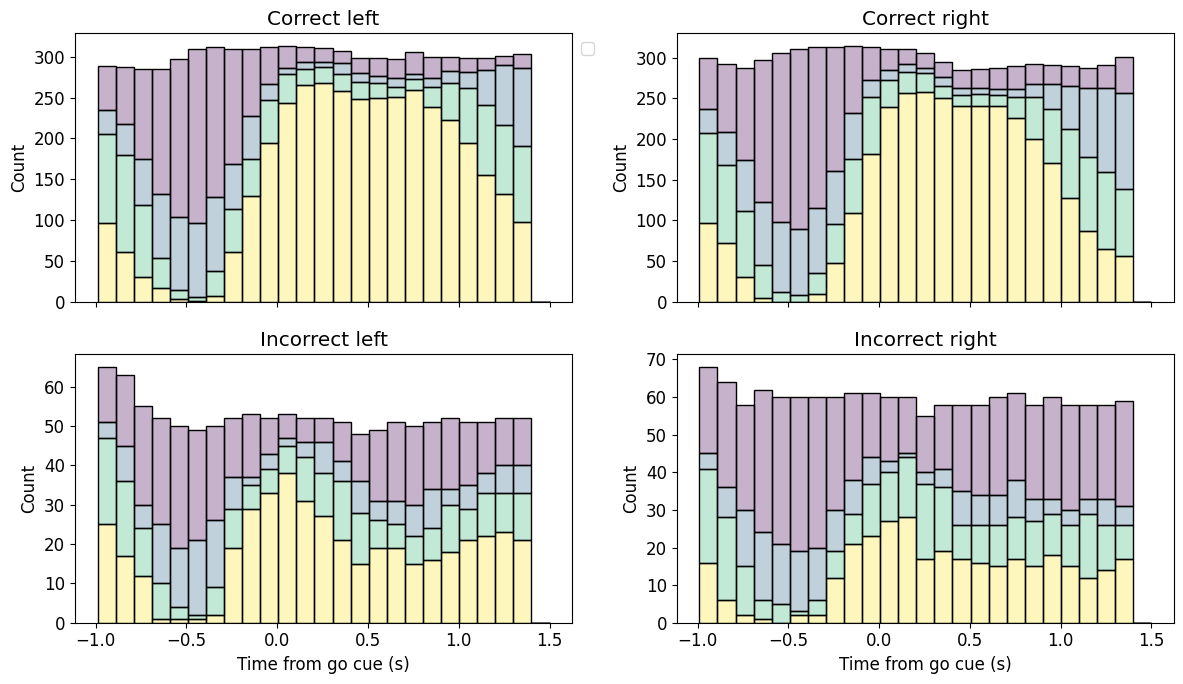

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['label'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on 

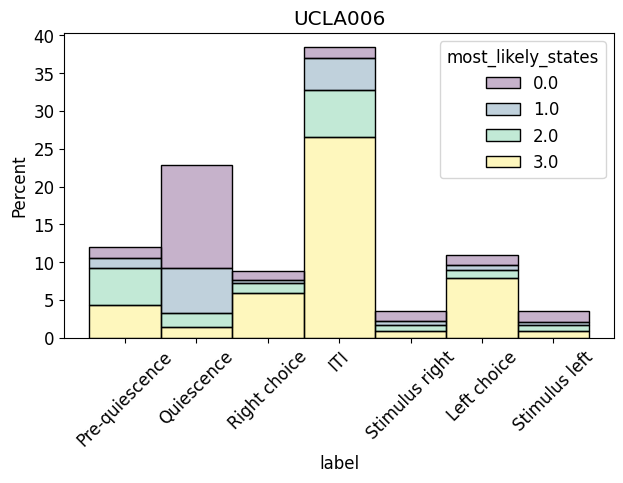

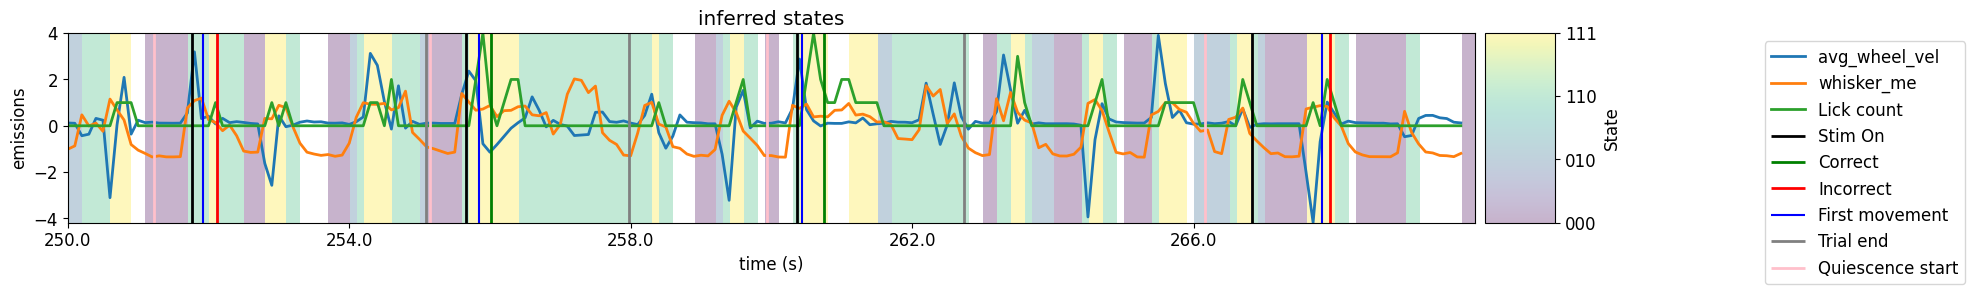

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_feedback'][1:] = trials['feedbackType'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

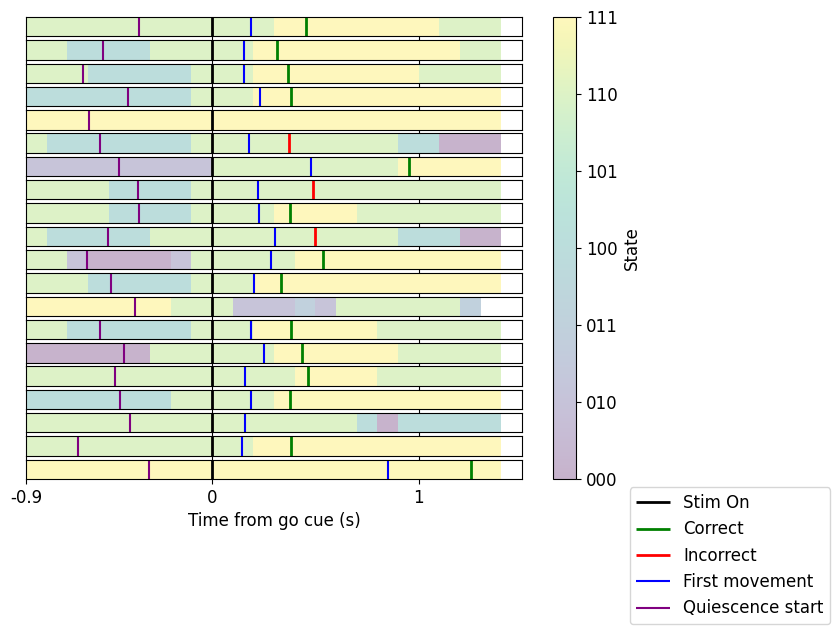

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:648: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


[]


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:677: UserWarning: Mismatched number of handles and labels: len(handles) = 0 len(labels) = 7
  ax[0, 0].legend(handles=handles, labels=ordered_labels, loc='upper left', bbox_to_anchor=(1, 1))
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:677: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0, 0].legend(handles=handles, labels=ordered_labels, loc='upper left', bbox_to_anchor=(1, 1))


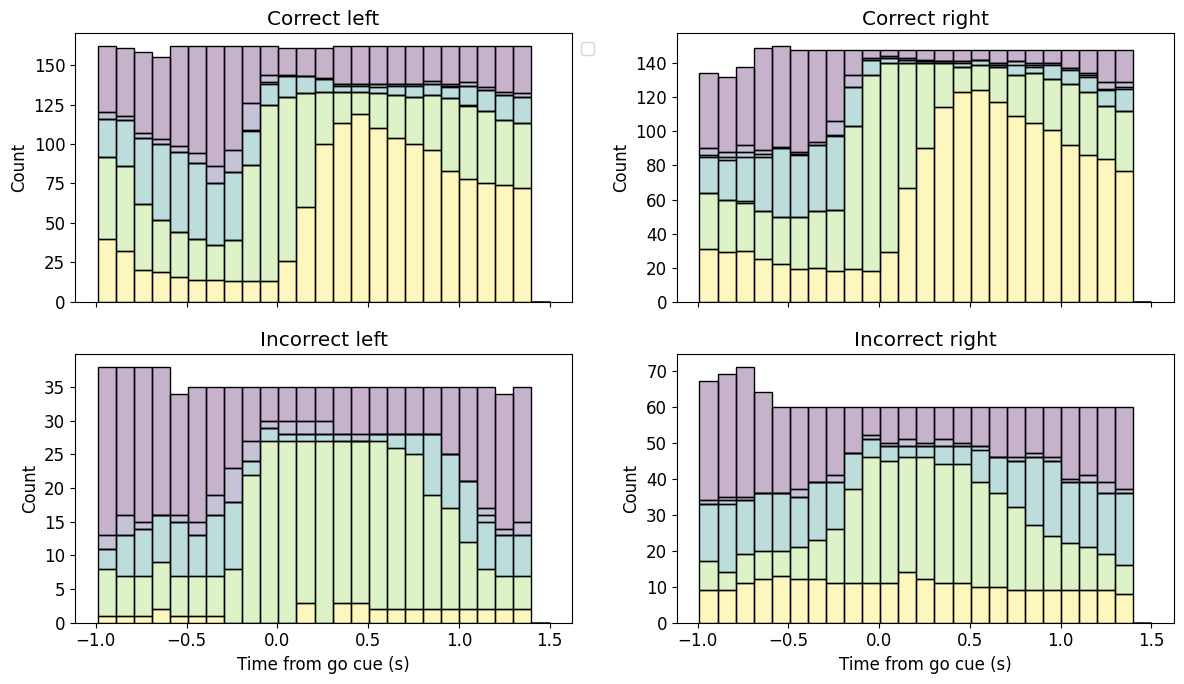

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['label'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on 

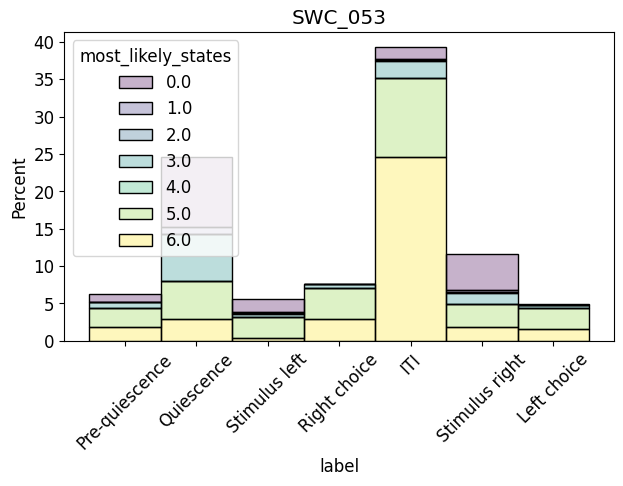

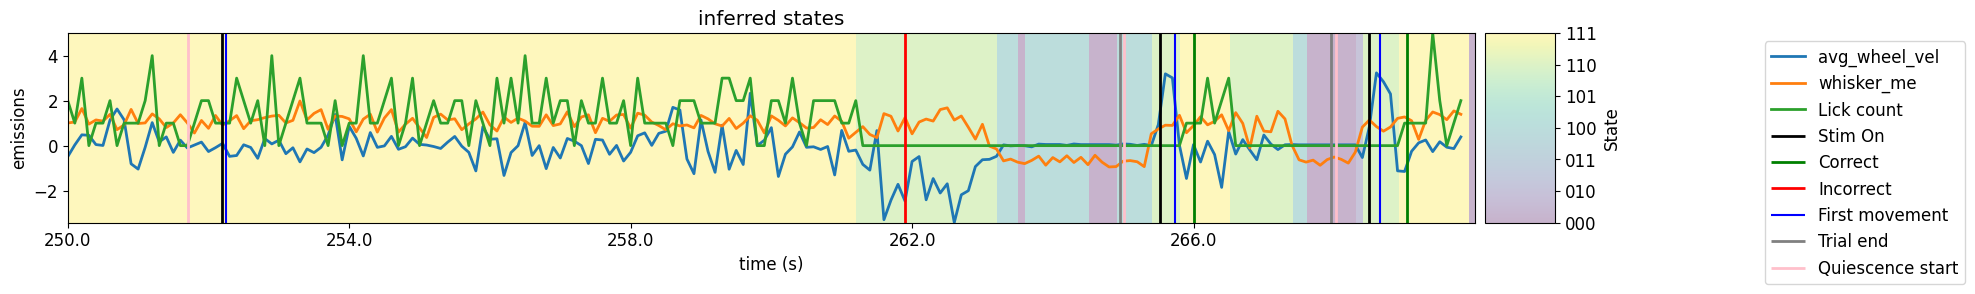

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_feedback'][1:] = trials['feedbackType'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

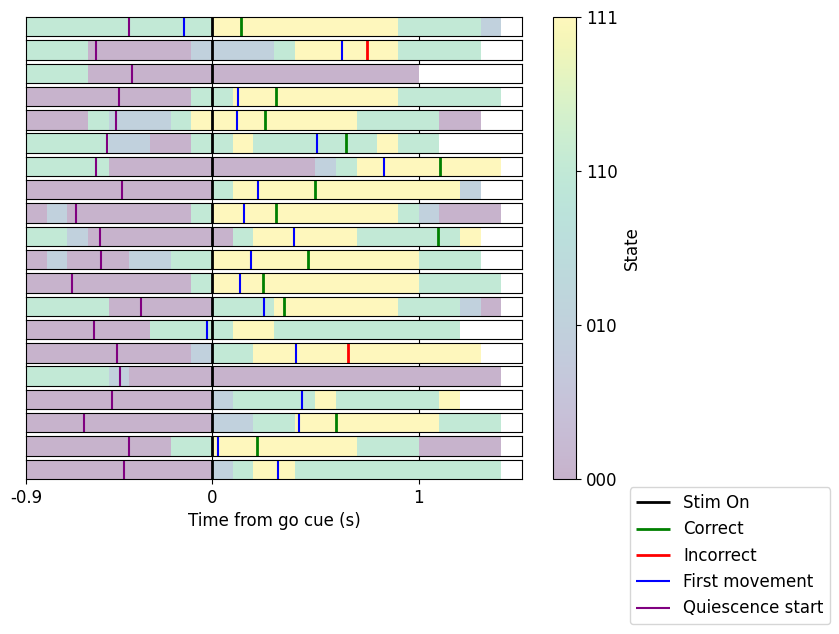

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:648: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:677: UserWarning: Mismatched number of handles and labels: len(handles) = 0 len(labels) = 4
  ax[0, 0].legend(handles=handles, labels=ordered_labels, loc='upper left', bbox_to_anchor=(1, 1))
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:677: UserWarning: No artists with labels found to put in legend.  Note that artists whose label st

[]


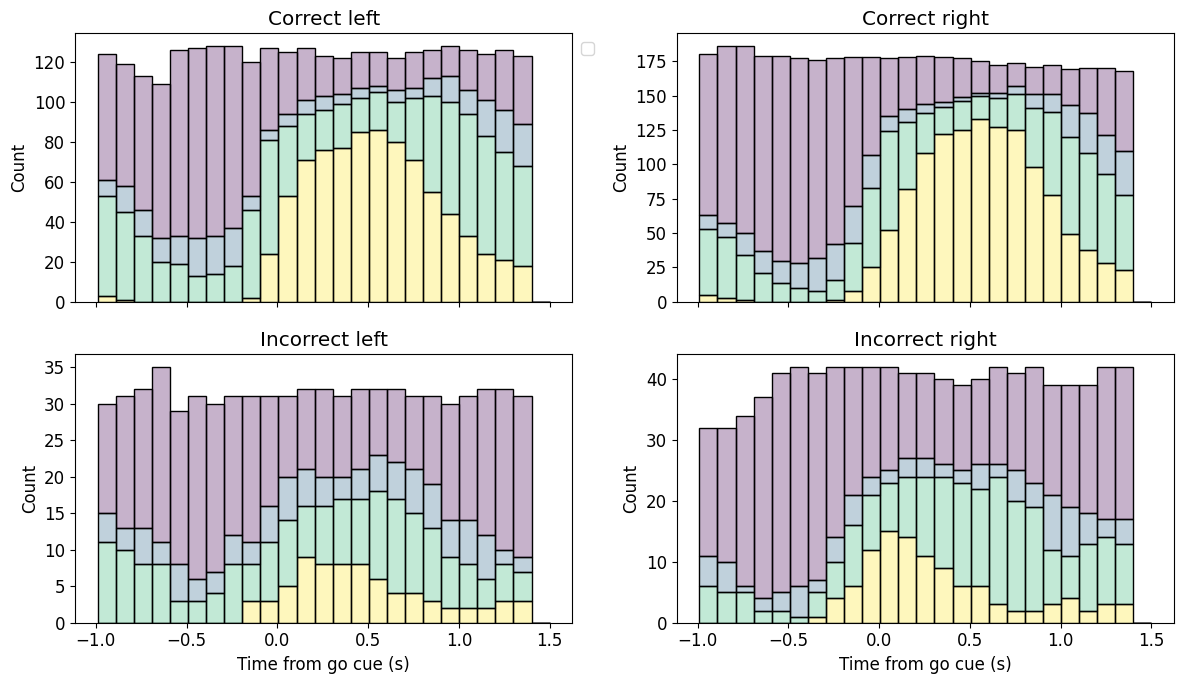

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['label'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on 

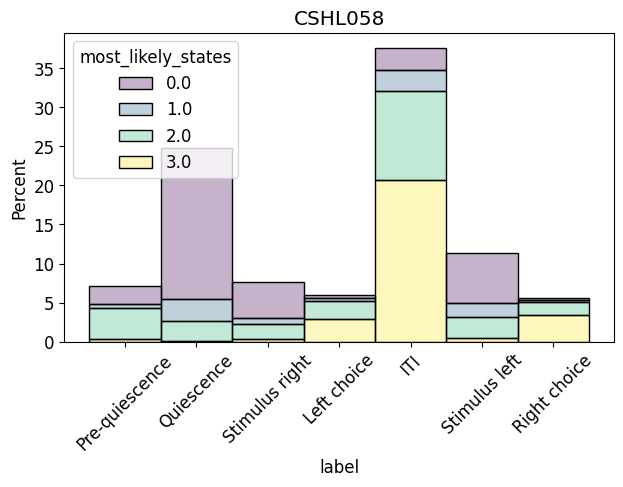

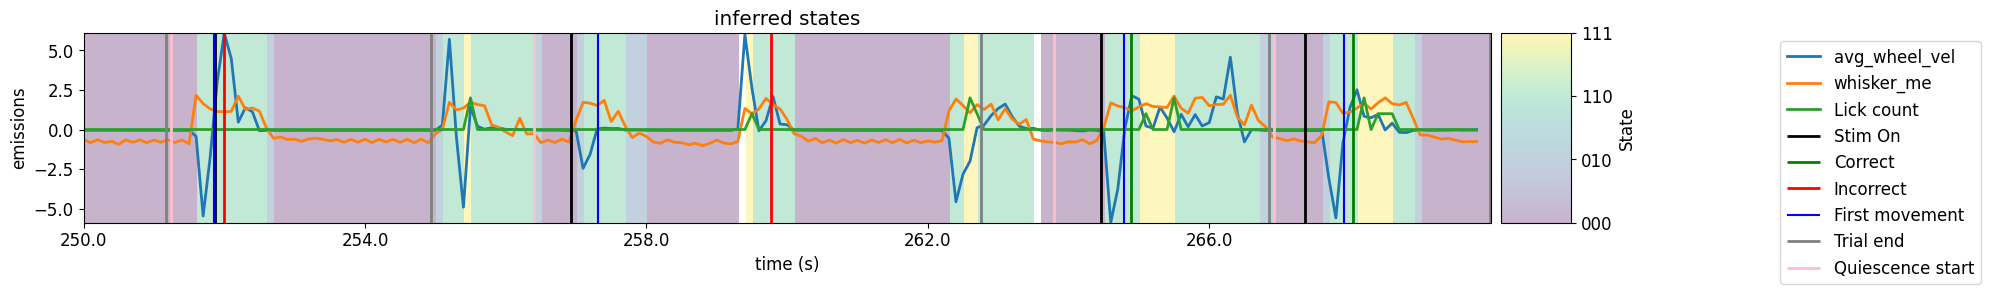

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_feedback'][1:] = trials['feedbackType'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

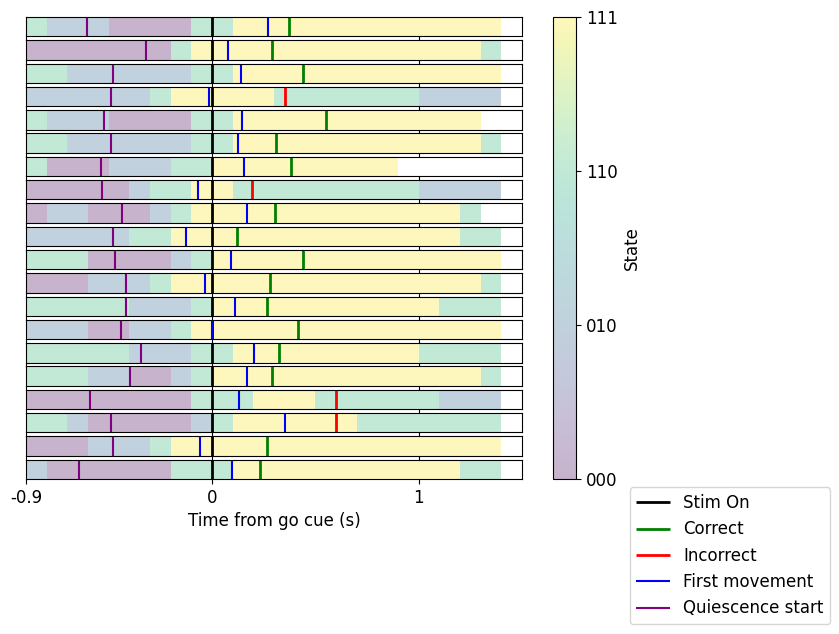

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:648: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:677: UserWarning: Mismatched number of handles and labels: len(handles) = 0 len(labels) = 4
  ax[0, 0].legend(handles=handles, labels=ordered_labels, loc='upper left', bbox_to_anchor=(1, 1))
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:677: UserWarning: No artists with labels found to put in legend.  Note that artists whose label st

[]


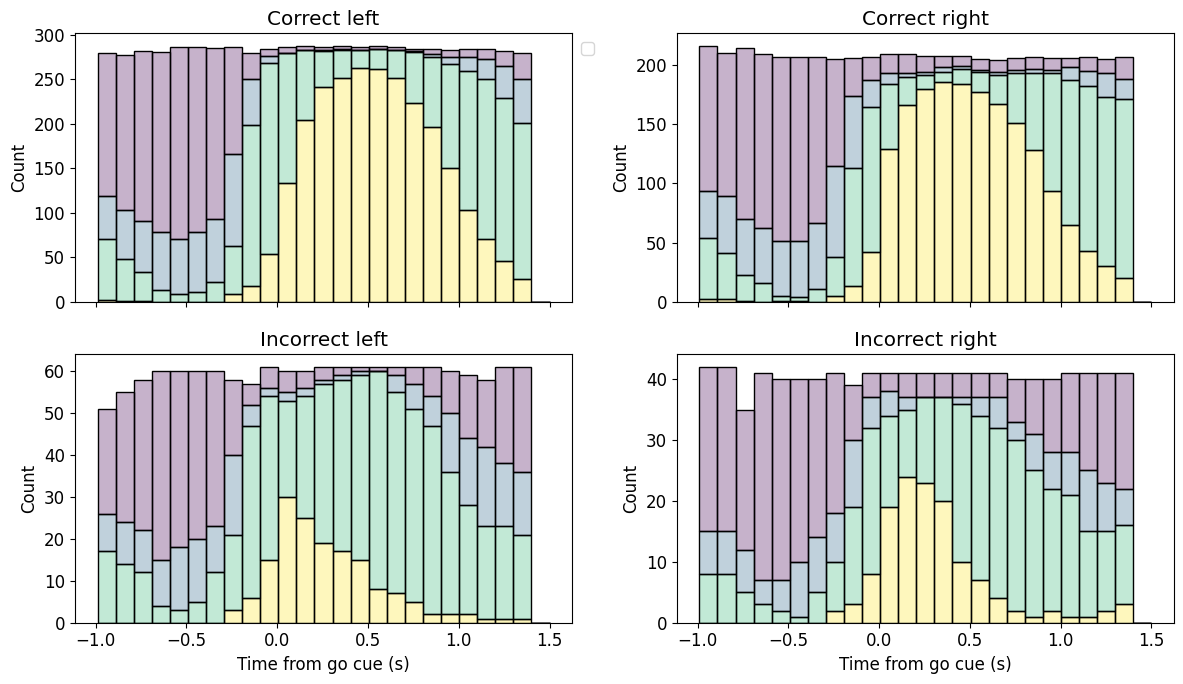

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['label'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on 

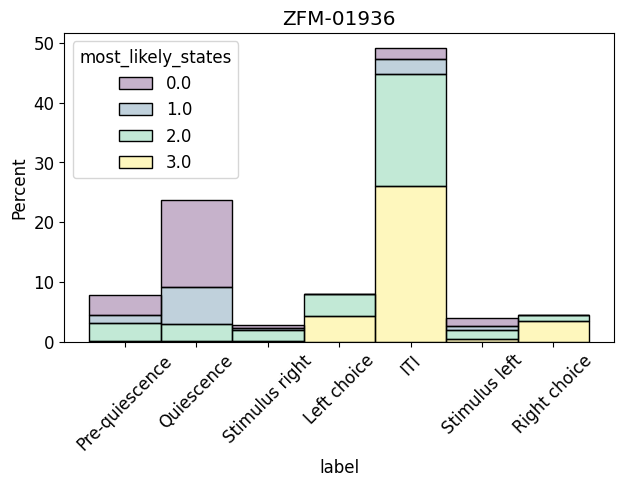

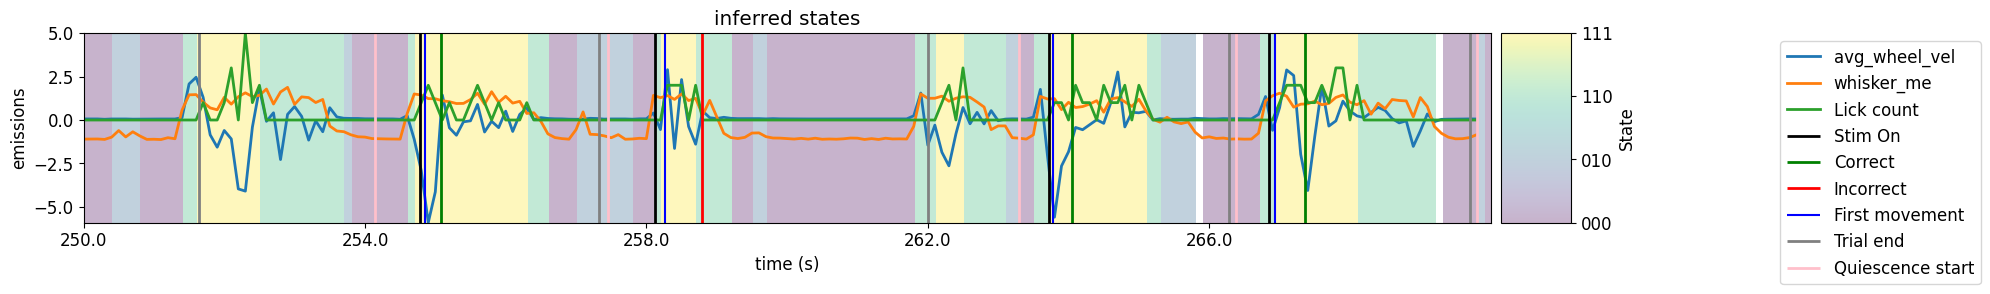

/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_feedback'][1:] = trials['feedbackType'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentati

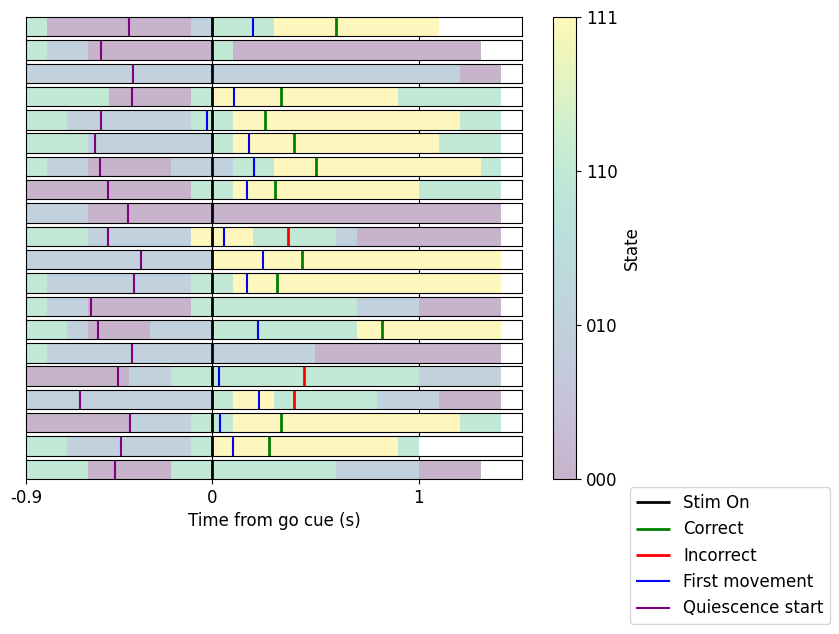

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:648: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['new_bin'] = use_data['new_bin'] * bin_size


[]


/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:677: UserWarning: Mismatched number of handles and labels: len(handles) = 0 len(labels) = 4
  ax[0, 0].legend(handles=handles, labels=ordered_labels, loc='upper left', bbox_to_anchor=(1, 1))
/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:677: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax[0, 0].legend(handles=handles, labels=ordered_labels, loc='upper left', bbox_to_anchor=(1, 1))


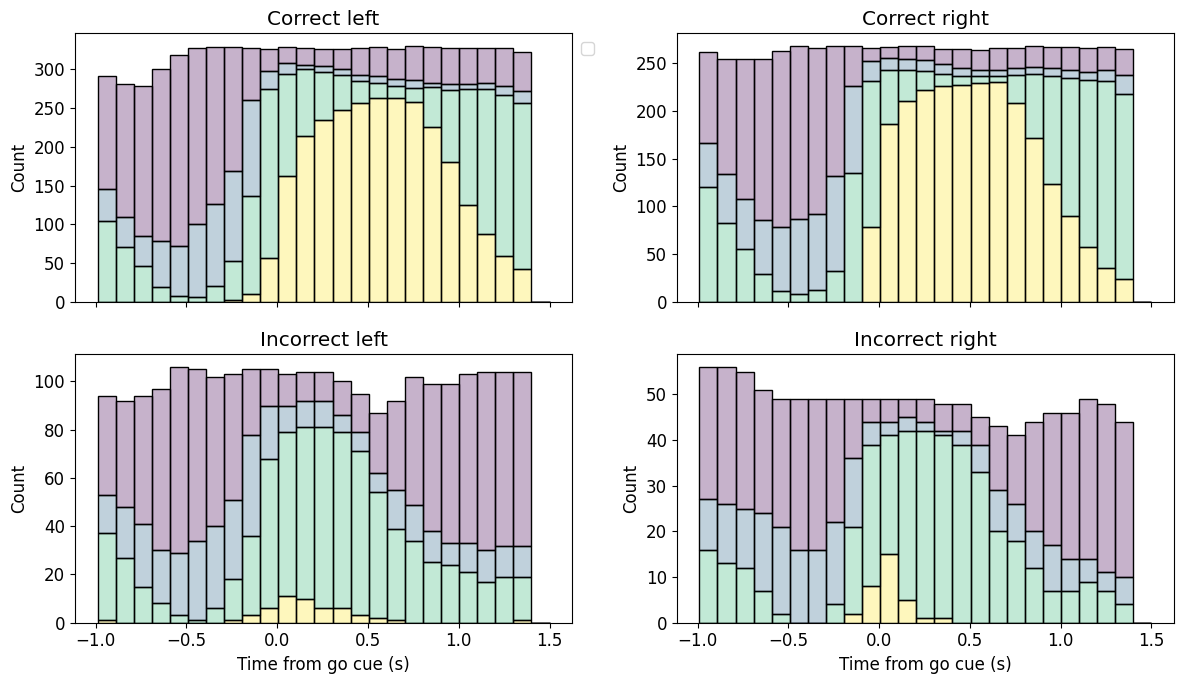

/home/ines/repositories/representation_learning_variability/Models/Sub-trial/3_postprocess_results/plotting_functions.py:238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  use_data['label'] = use_data['Bin'] * np.nan
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:530: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials['prev_choice'][1:] = trials['choice'][:-1]
/home/ines/repositories/representation_learning_variability/Functions/one_functions_generic.py:532: SettingWithCopyWarning: 
A value is trying to be set on 

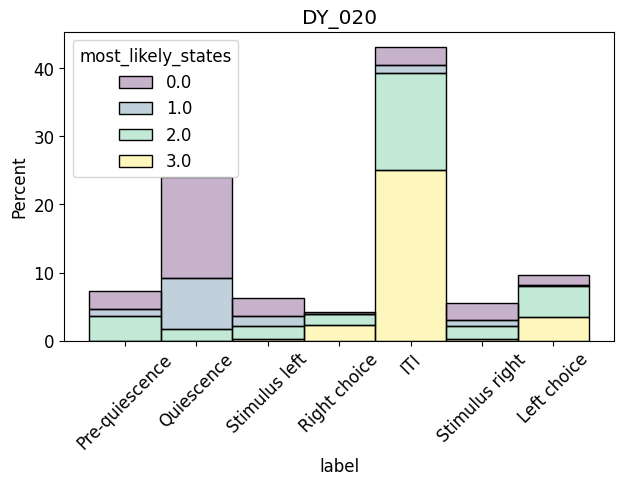

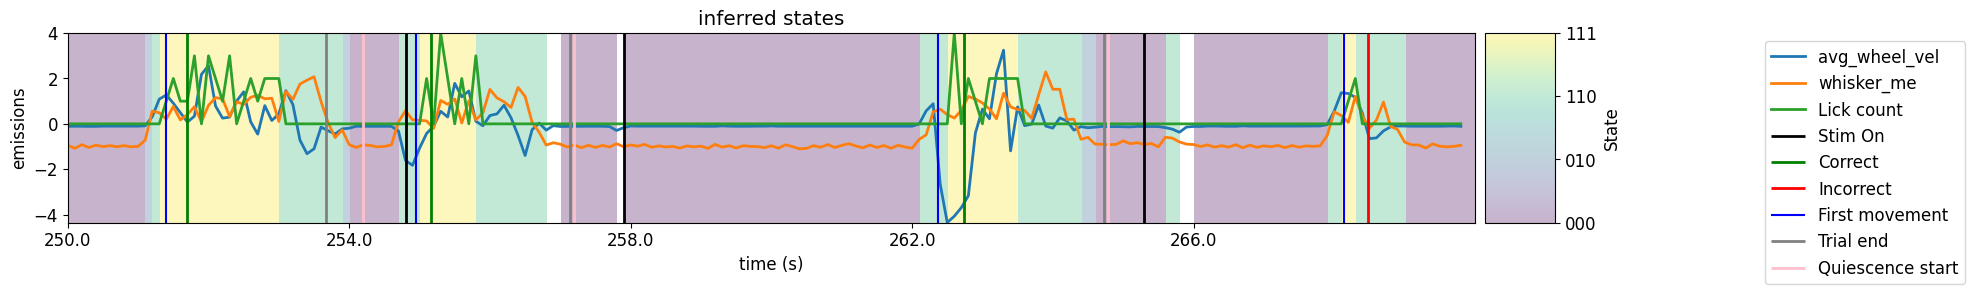

In [26]:
var_names = ['avg_wheel_vel',  'whisker_me', 'Lick count']

for m, mat in enumerate(idxs[:10]):
    if len(mat) > 35: 
        
        mouse_name = mat[37:]
        session = mat[0:36]
        
        if session not in exclude_sessions:

            # Get mouse data
            session_trials = session_all[mouse_name][session].reset_index()
            design_matrix = matrix_all[mouse_name][session][:,0:3]
            unnorm_mat = matrix_all_unnorm[mouse_name][session][var_names]
            unnorm_mat['Bin'] = matrix_all_unnorm[mouse_name][session]['Bin']

            # Get states per variable and concatenate
            num_states = 2
            states_path =  '/home/ines/repositories/representation_learning_variability/DATA/Sub-trial/Results/' + str(bin_size) + '/'+str(num_states)+'_states/most_likely_states/'
            os.chdir(states_path)
            
            c_states = []
            for s, set in enumerate(use_sets):
                
                most_likely_states, _ = pickle.load(open("most_likely_states" + set[0] + '_' + mouse_name + session, "rb"))
                # Save
                if len(c_states) == 0:
                    c_states = most_likely_states
                else:
                    c_states = np.vstack((c_states, most_likely_states))      
            
            combined_states = remove_states_str(c_states.T, threshold)
            
            " Prepare data "
            num_timesteps = np.shape(design_matrix)[0]
            design_matrix_heading = pd.DataFrame(columns=var_names)
            design_matrix_heading[var_names] = design_matrix[0:len(combined_states)]  # TODO: need to understand why number is the same and whether it depends on lag
            bins = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Bin']
            design_matrix_heading['Bin'] = bins
            design_matrix_heading['Lick count'] = unnorm_mat[:(num_timesteps // num_train_batches) * num_train_batches]['Lick count']
            
            # Transform states into identifiable states
            identifiable_states = state_identifiability(combined_states, design_matrix_heading, use_sets)
            
            # Change states back to integer
            state_labels = np.unique(identifiable_states)
            int_state = np.arange(0, len(state_labels), 1).astype(float)
            if state_labels[-1] == 'nan':
                int_state[-1] = np.nan
            # Define the mapping as a dictionary
            mapping = {unique: key for unique, key in zip(state_labels, int_state)}
            inverted_mapping = {v: k for k, v in mapping.items()}

            # Use np.vectorize to apply the mapping
            replace_func = np.vectorize(mapping.get)
            new_states = replace_func(identifiable_states)
            num_states = len(np.unique(new_states))

            # Align bins
            init = -1 * multiplier
            end = 1.5 * multiplier
            empirical_data = align_bin_design_matrix(init, end, event_type_list, session_trials, design_matrix_heading, new_states, multiplier)
            empirical_data['identifiable_states'] = identifiable_states
            states_trial = states_per_trial_phase(empirical_data, session_trials, multiplier)

            """ Stack trial states """
            trial_init = 10  # First trial to plot
            trials_to_plot = 20  # How many trials to plot (if very different will compromise readibility)
            plot_states_aligned_trial(trial_init, empirical_data, session_trials, bin_size, trials_to_plot, inverted_mapping)

            " Plot states stacked and aligned per trial type "
            plot_states_aligned(init, end, empirical_data, event_type_name, bin_size, inverted_mapping)
            
            """ Plot states per trial epoch """
            colors = sns.color_palette("viridis", num_states)
            # states_trial = states_per_trial_phase(empirical_data, session_trials, multiplier)
            states_trial = states_per_trial_phase(empirical_data, session_trials, multiplier)
            sns.histplot(x='label', hue='most_likely_states', data=states_trial, stat = 'percent',
                                multiple="stack", legend=True, palette='viridis', alpha=0.3)
            # plt.figure(figsize=[7, 5])
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.title(mouse_name)
            plt.show()
        
            """ Plot raw traces over states """
            init = int(np.min(empirical_data['Bin'])/10+10) * multiplier # First bin
            init = 250*multiplier
            inter = 10 * multiplier
            inter = 20 * multiplier
            traces_over_few_sates(init, inter, empirical_data, session_trials, var_names, multiplier, inverted_mapping)
            
        else:
            print(session)
            

In [103]:
unique_states = np.unique(combined_states)
new_states = unique_states.copy()

# Create new mapping depending on empirical data for each state
for v, var in enumerate(use_sets):
    zeros = [s[v] == '0' if s != 'nan' else False for s in combined_states]
    ones = [s[v] == '1' if s != 'nan' else False for s in combined_states]
    if var == ['avg_wheel_vel']:
        var_0 = np.array(np.abs(design_matrix_heading[var]))[zeros]
        var_1 = np.array(np.abs(design_matrix_heading[var]))[ones]
    elif var == ['left_X', 'left_Y', 'right_X', 'right_Y']:
        var_0 = np.array(np.abs(np.diff(design_matrix_heading[var], axis=0)))[zeros[1:]]
        var_1 = np.array(np.abs(np.diff(design_matrix_heading[var], axis=0)))[ones[1:]]
    elif var == ['nose_x', 'nose_Y']:
        print('Not implemented yet')
    else:
        var_0 = np.array(design_matrix_heading[var])[zeros]
        var_1 = np.array(design_matrix_heading[var])[ones]
    
    if np.nanmean(var_0)> np.nanmean(var_1):
        var_state_0 = [s[v] == '0' if s != 'nan' else False for s in unique_states]
        new_states[var_state_0] = np.array([s[:v] + '1' + s[v+1:] for s in new_states[var_state_0]])
        var_state_1 = [s[v] == '1' if s != 'nan' else False for s in unique_states]
        new_states[var_state_1] = np.array([s[:v] + '0' + s[v+1:] for s in new_states[var_state_1]])


identifiable_mapping = {unique: key for unique, key in zip(unique_states, new_states)}

# Use np.vectorize to apply the mapping
replace_func = np.vectorize(identifiable_mapping.get)
identifiable_states = replace_func(combined_states)

In [108]:
def state_identifiability(combined_states, design_matrix_heading, use_sets):
    
    unique_states = np.unique(combined_states)
    new_states = unique_states.copy()

    # Create new mapping depending on empirical data for each state
    for v, var in enumerate(use_sets):
        zeros = [s[v] == '0' if s != 'nan' else False for s in combined_states]
        ones = [s[v] == '1' if s != 'nan' else False for s in combined_states]
        if var == ['avg_wheel_vel']:
            var_0 = np.array(np.abs(design_matrix_heading[var]))[zeros]
            var_1 = np.array(np.abs(design_matrix_heading[var]))[ones]
        elif var == ['left_X', 'left_Y', 'right_X', 'right_Y']:
            var_0 = np.array(np.abs(np.diff(design_matrix_heading[var], axis=0)))[zeros[1:]]
            var_1 = np.array(np.abs(np.diff(design_matrix_heading[var], axis=0)))[ones[1:]]
        elif var == ['nose_x', 'nose_Y']:
            print('Not implemented yet')
        else:
            var_0 = np.array(design_matrix_heading[var])[zeros]
            var_1 = np.array(design_matrix_heading[var])[ones]
        
        if np.nanmean(var_0)> np.nanmean(var_1):
            var_state_0 = [s[v] == '0' if s != 'nan' else False for s in unique_states]
            new_states[var_state_0] = np.array([s[:v] + '1' + s[v+1:] for s in new_states[var_state_0]])
            var_state_1 = [s[v] == '1' if s != 'nan' else False for s in unique_states]
            new_states[var_state_1] = np.array([s[:v] + '0' + s[v+1:] for s in new_states[var_state_1]])


    identifiable_mapping = {unique: key for unique, key in zip(unique_states, new_states)}

    # Use np.vectorize to apply the mapping
    replace_func = np.vectorize(identifiable_mapping.get)
    identifiable_states = replace_func(combined_states)
    
    return identifiable_states